### OpenAI gym

In [1]:
!apt-get install -y xvfb x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 993 kB in 1s (760 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1

In [2]:
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

     |████████████████████████████████| 538 kB 8.9 MB/s 
     |████████████████████████████████| 448 kB 43.1 MB/s 
  Created wheel for PyOpenGL-accelerate: filename=PyOpenGL_accelerate-3.1.5-cp37-cp37m-linux_x86_64.whl size=1599456 sha256=05946acc6709b3c26b69dafbc9172fe2f1f8c9ee316819e6db87d7bb6c2336bc
  Stored in directory: /root/.cache/pip/wheels/1c/f5/6f/169afb3f2d476c5e807f8515b3c9bc9b819c3962316aa804eb
Successfully built PyOpenGL-accelerate


In [3]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [4]:
import gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, callbacks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [ ]:
env = gym.make('CartPole-v1')

In [ ]:
env.seed(42)
obs = env.reset()
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

In [ ]:
env.action_space

Discrete(2)

In [ ]:
def plot_enviroment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.show()
    print(img.shape)

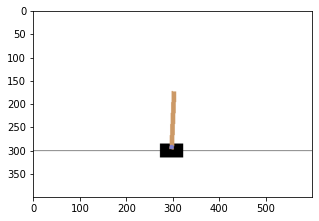

(400, 600, 3)


In [ ]:
plot_enviroment(env)

In [ ]:
action = 1
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

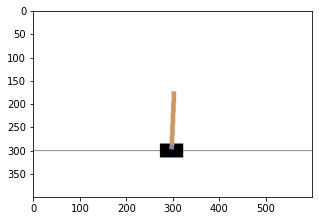

(400, 600, 3)


In [ ]:
plot_enviroment(env)

In [ ]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

obs_imgs = []
total = []
for episode in range(500):
    episode_reward = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        if done:
            break
    total.append(episode_reward)
    obs_imgs.append(env.render(mode="rgb_array"))

In [ ]:
np.mean(total), np.std(total), np.min(total), np.max(total)

(41.684, 8.839917646675222, 24.0, 68.0)

In [ ]:
env.seed(42)
frames = []

obs = env.reset()
for step in range(500):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    if done:
        break

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis("off")
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch), 
        frames=len(frames), repeat=repeat, interval=interval
    )
    plt.close()
    return anim

In [ ]:
plot_animation(frames)

### Neural Network  policies

In [ ]:
n_inputs = 4

model = Sequential([
            layers.Dense(5, activation="elu", input_shape=[n_inputs]), 
            layers.Dense(1, activation="sigmoid")
])

In [ ]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1,1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [ ]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [ ]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) -2, -1, -1):
        discounted[step] += discounted[step+1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) 
    for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std 
            for discounted_rewards in all_discounted_rewards]

In [ ]:
discount_rewards([10, 0, -50], 0.8)

array([-22, -40, -50])

In [ ]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [ ]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, 
                                                    n_max_steps, model, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index] 
             for episode_index, final_rewards in enumerate(all_final_rewards) 
             for step, final_reward in enumerate(final_rewards)], 
            axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))


### Markov decision Process

In [15]:
transition_probabilities = [
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], 
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]], 
        [None, [0.8, 0.1, 0.1], None]]
rewards = [
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]], 
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]], 
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [16]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

In [17]:
gamma = 0.90
history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum(
                [transition_probabilities[s][a][sp] * 
                 (rewards[s][a][sp] + gamma * np.max(Q_prev[sp])) 
                 for sp in range(3)])
history1 = np.array(history1)

In [18]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [19]:
np.argmax(Q_values, axis=1)

array([0, 0, 1])

### Q-Learning

In [20]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [21]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [22]:
Q_values = np.full((3, 3), -np.inf)
for state, action in enumerate(possible_actions):
    Q_values[state][action] = 0

alpha0 = 0.05
decay = 0.005
gamma = 0.90
state = 0
history2 = []
for iteration in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1  + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state
history2 = np.array(history2)

In [23]:
np.argmax(Q_values, axis=1)

array([0, 0, 1])

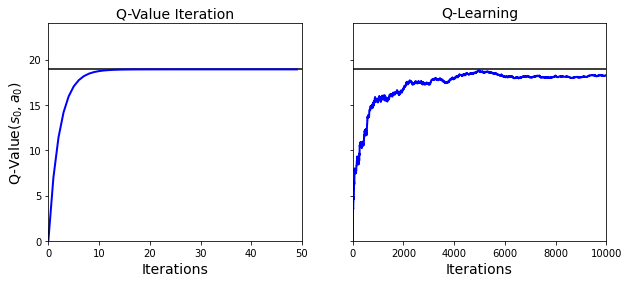

In [25]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k-")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
